We now extend SEIR model to:

\begin{align}
\dot{S_{i}}	&=-\lambda_{i}(t)S_{i}+\sigma_{i}, \\
\dot{E}_{i}	&=\lambda_{i}(t)S_{i}-\gamma_{E}E_{i},\\
\dot{I}_{i}^{a}	&=\alpha\gamma_{E}E_{i}-\gamma_{I^{a}}I_{i}^{a},\\
\dot{I}_{i}^{s}	&=\bar{\alpha}\gamma_{E}E_{i}-\gamma_{I^{s}}I_{i}^{s},\\
\dot{I}_{i}^{h}	&=h_{i}\gamma_{I^{s}}I_{i}^{s}-\gamma_{I^{h}}I_{i}^{h},\\
\dot{I}_{i}^{c}	&=c_{i}\gamma_{I^{h}}I_{i}^{h}-\gamma_{I^{c}}I_{i}^{c},\\
\dot{I}_{i}^{m}	&=m_{i}\gamma_{I^{c}}I_{i}^{c},\\
\dot{R}_{i} &=\gamma_{I^{a}}I_{i}^{a}+\bar{h}_{i}\gamma_{I^{s}}I_{i}^{s}+\bar{c}_{i}\gamma_{I^{h}}I_{i}^{h}+\bar{m}_{i}\gamma_{I^{c}}I_{i}^{c},\\
\dot{N}_{i}	&=\sigma_{i}-I_{i}^{m}.
\end{align}


$\lambda_{i}(t)=\beta\sum_{j=1}^{M}\left(C_{ij}^{a}\frac{I_{j}^{a}}{N_{j}}+C_{ij}^{s}\frac{I_{j}^{s}}{N_{j}}+C_{ij}^{h}\frac{I_{j}^{h}}{N_{j}}\right)$.

Here 
* $I^{a}$ : asymptomatic infectives
* $I^{s}$ : symptomatic infectives
* $I^{h}$ : hospitalized infectives
* $I^{c}$ : ICU cases 
* $I^{m}$ : mortality
* ${h}_{i}=1-\bar h_{i}$ is the fraction of syptomatics who are hospitalized
* $c_{i}=1-\bar{c}_{i}$, is the fraction of hospitalizeds, who are in ICU
* $m_{i}=1-\bar{m}_{i}$, is the fraction of ICU which leads to mortality
* $C_{ij}^{s}=f^{s}C_{ij}^{a}\equiv f^{s}C_{ij}$  
* $C_{ij}^{h}=f^{h}C_{ij}^{a}\equiv f^{h}C_{ij}$. 

S ---> E ---> Ia, Is 

Ia ---> R

Is ---> Ih, R

Ih ---> Ic, R

Ic ---> Im, R

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

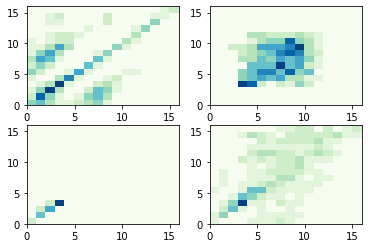

In [4]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain')
CH0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CW0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CS0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CO0 = np.array(my_data)

CH = np.zeros((16, 16))
CH[0,:]= np.array((0.478812799633172, 0.55185413960287,0.334323605154544,0.132361228266194,0.138531587861408,0.281604887066586,0.406440258772792,0.493947983343078,0.113301080935514,0.0746826413664804,0.0419640342896305,0.0179831987029717,0.00553694264516568,0.00142187285266089,0,0.000505582193632659))
for i in range(15):
    CH[i+1, :] = CH0[i, :]

    
CW = np.zeros((16, 16))
CW[0,:]= np.array((0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000820604524144799,0.0000120585150153575,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000316436833811157))
for i in range(15):
    CW[i+1, :] = CW0[i, :]

    
CS = np.zeros((16, 16))
CS[0,:]= np.array((0.974577996106766,0.151369805263473,0.00874880925953218,0.0262790907947637,0.0111281607429249,0.0891043051294382,0.125477587043249,0.0883182775274553,0.0371824197201174,0.0294092695284747,0.0000000000000000000000000000000000000510911446027435,0.0000000000000000000000000000000113982464440009,0.00758428705895781,0.00151636767747242,0.0000000000000000000000000000000000000000000000000123262013953524,0.000000000000000000000000000000000000000000000000000000000000000597486362181075))
for i in range(15):
    CS[i+1, :] = CS0[i, :]

CO = np.zeros((16, 16))
CO[0,:]= np.array((0.257847576361162,0.100135168376607,0.0458036773638843,0.127084549151753,0.187303683093508,0.257979214509792,0.193228849121415,0.336594916946786,0.309223290169635,0.070538522966953,0.152218422246435,0.113554851510519,0.0615771477785246,0.040429874099682,0.0373564987094767,0.00669781557624776))
for i in range(15):
    CO[i+1, :] = CO0[i, :]

## matrix of total contacts
C=CH+CW+CS+CO



fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [5]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                   # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 100*np.ones(M)      # arrival of new susceptibles
sa[0] = 1500

iaa   = 10*np.ones(M)       # daily arrival of new  asymptomatics

hh   = 10*np.ones(M)      
cc   = 10*np.ones(M)      
mm   = 0*np.ones(M)      






# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

Ia_0 = np.zeros((M));  Ia_0[6:13]=4;  Ia_0[2:6]=2; Ia_0[13:16]=2
R_0  = np.zeros((M))
E_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.319908017634234+0j)


42.0

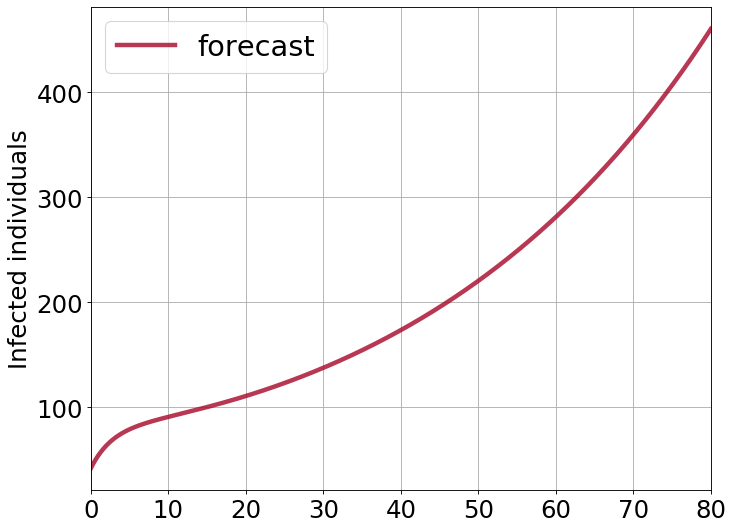

In [6]:
# duration of simulation and data file
Tf=80;  Nf=2000;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'iaa':iaa,
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEI5R(parameters, M, Ni)



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0,E_0,Ia_0,Is_0,Ih_0,Ic_0,Im_0, contactMatrix, Tf, Nf)


t = data['t']; IC  = np.zeros((Nf))
for i in range(2*M):
        IC += data['X'][:,M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]